## Import Libraries

In [362]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [363]:
Football = pd.read_csv("D:/Documents/Downloads/usecase 7 tuwaiq/Usecase-7/final_data.csv") 

In [364]:
Football.shape

(10754, 22)

In [365]:
pd.set_option('display.max_columns', None)
Football.head(2)

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [366]:
Football.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10754 entries, 0 to 10753
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player               10754 non-null  object 
 1   team                 10754 non-null  object 
 2   name                 10754 non-null  object 
 3   position             10754 non-null  object 
 4   height               10754 non-null  float64
 5   age                  10754 non-null  float64
 6   appearance           10754 non-null  int64  
 7   goals                10754 non-null  float64
 8   assists              10754 non-null  float64
 9   yellow cards         10754 non-null  float64
 10  second yellow cards  10754 non-null  float64
 11  red cards            10754 non-null  float64
 12  goals conceded       10754 non-null  float64
 13  clean sheets         10754 non-null  float64
 14  minutes played       10754 non-null  int64  
 15  days_injured         10754 non-null 

In [367]:
# uniqeness
Football.drop_duplicates(inplace=True)
Football[Football.duplicated()]

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger


In [368]:
# Completeness
Football.isnull().sum()

player                 0
team                   0
name                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
position_encoded       0
winger                 0
dtype: int64

In [369]:
# Accurecy types
Football.dtypes


player                  object
team                    object
name                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
dtype: object

In [370]:
# Drop 'player' and 'position' directly from Football DataFrame
Football.drop(columns=['player', 'position','name'], inplace=True)

# Define updated categorical and numerical features
categorical_features = ['team']
numeric_features = [
    'height', 'age', 'appearance', 'goals', 'assists', 'yellow cards',
    'second yellow cards', 'red cards', 'goals conceded', 'clean sheets',
    'minutes played', 'days_injured', 'games_injured', 'award',
    'current_value', 'highest_value', 'position_encoded', 'winger'
]

# Print value counts for categorical features
for feature in categorical_features:
    print(f"Value counts for {feature}:\n{Football[feature].value_counts()}\n")

Value counts for team:
team
Daejeon Hana Citizen      46
Jeonbuk Hyundai Motors    46
FC Seoul                  45
Gangwon FC                43
Daegu FC                  42
                          ..
FC Barcelona              22
Atlético de Madrid        22
CA Osasuna                22
Hatayspor                 12
Gaziantep FK               6
Name: count, Length: 374, dtype: int64



In [371]:
print(f"Shape after dropping columns: {Football.shape}")


Shape after dropping columns: (10754, 19)


#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [372]:
categorical_features

['team']

In [373]:
Football = pd.get_dummies(Football, columns=categorical_features, sparse=True)

In [374]:
print(f"Shape after one-hot encoding: {Football.shape}")


Shape after one-hot encoding: (10754, 392)


In [375]:
# Calculate the 35th and 75th percentiles of 'current_value'
p35 = Football['current_value'].quantile(0.35)
p75 = Football['current_value'].quantile(0.75)

# Function to categorize market value
def categorize_market_value(value):
    if value < p35:
        return 'Low_Value'
    elif value < p75:
        return 'Mid_Value'
    else:
        return 'High_Value'

# Apply the function to create a new category column
Football['market_value_category'] = Football['current_value'].apply(categorize_market_value)

# Drop 'current_value' after categorization (if needed)
Football.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(Football['market_value_category'].value_counts())

market_value_category
Mid_Value     4310
Low_Value     3754
High_Value    2690
Name: count, dtype: int64


In [376]:
p35, p75

(450000.0, 3000000.0)

In [377]:
Football['market_value_category'].head()  

0    High_Value
1     Mid_Value
2     Mid_Value
3    High_Value
4    High_Value
Name: market_value_category, dtype: object

In [378]:
encoder = LabelEncoder()
Football['market_value_category_encoded'] = encoder.fit_transform(Football['market_value_category'])

#### 3. Feature selection

In [379]:
# Compute correlation only with 'market_value_category_encoded'
numeric_cols = Football.select_dtypes(include=['number']).columns
target_corr = Football[numeric_cols].corrwith(Football['market_value_category_encoded'])

print("Feature Correlation with 'market_value_category_encoded':")
print(target_corr.sort_values(ascending=False))

Feature Correlation with 'market_value_category_encoded':
market_value_category_encoded    1.000000
age                              0.106704
yellow cards                     0.023866
winger                           0.023600
goals conceded                   0.018957
red cards                        0.012175
second yellow cards              0.005515
clean sheets                    -0.001789
position_encoded                -0.017417
days_injured                    -0.045211
height                          -0.056052
assists                         -0.056219
games_injured                   -0.064487
goals                           -0.064583
award                           -0.134200
minutes played                  -0.238808
appearance                      -0.243714
highest_value                   -0.413106
dtype: float64


In [380]:
# Compute correlation with target efficiently
numeric_cols = Football.select_dtypes(include=['number']).columns
target_corr = Football[numeric_cols].corrwith(Football['market_value_category_encoded']).abs()

# Automatically determine the best correlation threshold
thresholds = np.arange(0.1, 0.6, 0.1)  # Testing thresholds from 0.1 to 0.5
best_threshold = 0.1  # Default to minimum threshold
best_features = []
max_features = 0

for threshold in thresholds:
    # Select features above threshold (excluding target)
    temp_features = target_corr[target_corr > threshold].index.drop('market_value_category_encoded', errors='ignore').tolist()
    
    # Update if more features are selected
    if len(temp_features) > max_features:
        best_threshold = threshold
        max_features = len(temp_features)
        best_features = temp_features

# Final selected features (add target back as it's needed for modeling)
selected_features = best_features + ['market_value_category_encoded']

# Display results
print(f"Best Correlation Threshold: {best_threshold:.1f}")
print(f"Selected Features ({len(selected_features) - 1} features + target variable): {selected_features}")

Best Correlation Threshold: 0.1
Selected Features (5 features + target variable): ['age', 'appearance', 'minutes played', 'award', 'highest_value', 'market_value_category_encoded']


In [381]:
selected_features = ['age', 'appearance', 'minutes played', 'award', 'highest_value', 'market_value_category_encoded']

# Select only the chosen features
Football = Football[selected_features]

# Display first few rows of the updated dataset
Football.head()


,age,appearance,minutes played,award,highest_value,market_value_category_encoded
0,32.0,104,9390,13,70000000,0
1,30.0,15,1304,1,22000000,2
2,37.0,4,292,4,6000000,2
3,25.0,82,6408,9,50000000,0
4,30.0,63,5031,21,80000000,0


#### 4. Prepare train and test data

In [382]:
# Prepare data
X = Football.drop(['market_value_category_encoded'], axis=1)  # Features
y = Football['market_value_category_encoded']  # Target variable

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

# Scale the data (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Print dataset shapes to confirm
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")


Training set: (8603, 5), Testing set: (2151, 5)


In [383]:
Football.columns

Index(['age', 'appearance', 'minutes played', 'award', 'highest_value',
       'market_value_category_encoded'],
      dtype='object')

In [384]:
X.shape

(10754, 5)

## Buliding the Model

In [385]:
model = LogisticRegression()

## Train the Model

In [386]:
# Fit the model on the training data
model.fit(X_train_scaled, y_train)

LogisticRegression()

## Test the Model

In [387]:
# Predict and evaluate the model
y_pred_test = model.predict(X_test_scaled)

## Interpretation of the Model

In [388]:
# Each row of the model.coef_ matrix tells you how each feature affects being in the corresponding class versus any other class
coeff_df = pd.DataFrame(model.coef_[2],X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
age,0.281252
appearance,0.170193
minutes played,-0.144720
award,0.111114
highest_value,1.613074


In [389]:
model.coef_

array([[-0.74783475,  0.11184881,  0.60151837, -0.28356474,  5.54695577],
       [ 0.46658266, -0.28204182, -0.45679842,  0.17245066, -7.16002996],
       [ 0.28125209,  0.17019301, -0.14471995,  0.11111408,  1.61307419]])

In [390]:
print(model.intercept_) 

[ 0.65359545 -2.0581739   1.40457846]


## Evaluating the Model 

In [391]:
# Compute the baseline model accuracy (benchmark)
base_model = round(Football['market_value_category_encoded'].value_counts().max() / Football.shape[0] * 100, 2)

# Display benchmark accuracy
print(f"Baseline Model Accuracy: {base_model}%")


Baseline Model Accuracy: 40.08%


1. Accuracy

In [392]:
# Train score
y_pred_train = model.predict(X_train_scaled)
accuracy_Train = accuracy_score(y_train, y_pred_train)
accuracy_Train

0.725560850865977

In [393]:
# Test score
accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_test

0.7159460715946072

- Confusion matrix

In [394]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
conf_matrix

array([[365,   0, 148],
       [  3, 617, 136],
       [ 48, 276, 558]], dtype=int64)

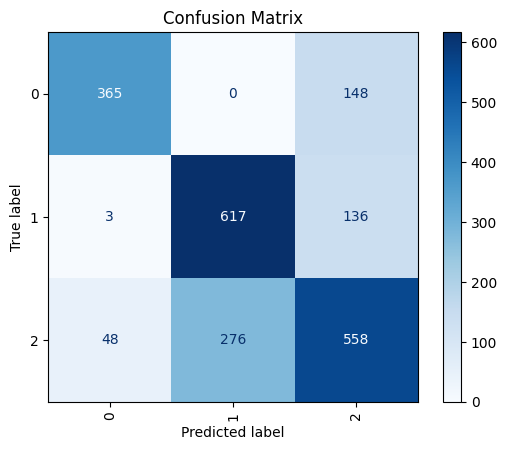

In [395]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test,
                                        display_labels=model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

2. Precision

In [396]:
# Train score
precision_train = precision_score(y_train, y_pred_train, average='macro')
print(f"Precision in train: {precision_train:.2f}")

# Test score
precision_test = precision_score(y_test, y_pred_test, average='macro')
print(f"Precision in test: {precision_test:.2f}")

Precision in train: 0.75
Precision in test: 0.74


3. Recall

In [397]:
# Train score
recall_train = recall_score(y_train, y_pred_train, average='macro')
print(f"Recall in train: {recall_train:.2f}")

# Test score
recall_test = recall_score(y_test, y_pred_test, average='macro')
print(f"Recall in test: {recall_test:.2f}")

Recall in train: 0.73
Recall in test: 0.72


4. F1-Score

In [398]:
# Train score
f1_train = f1_score(y_train, y_pred_train, average='macro')
print(f"f1-score in train: {f1_train:.2f}")

# Test score
f1_test = precision_score(y_test, y_pred_test, average='macro')
print(f"f1-score in test: {f1_test:.2f}")

f1-score in train: 0.73
f1-score in test: 0.74


- Classification report

In [399]:
from sklearn.metrics import classification_report

print('Train report: ')
print(classification_report(y_train, y_pred_train))

print('Test report: ')
print(classification_report(y_test, y_pred_test))

Train report: 
              precision    recall  f1-score   support

           0       0.88      0.71      0.79      2177
           1       0.71      0.83      0.76      2998
           2       0.66      0.65      0.65      3428

    accuracy                           0.73      8603
   macro avg       0.75      0.73      0.73      8603
weighted avg       0.73      0.73      0.73      8603

Test report: 
              precision    recall  f1-score   support

           0       0.88      0.71      0.79       513
           1       0.69      0.82      0.75       756
           2       0.66      0.63      0.65       882

    accuracy                           0.72      2151
   macro avg       0.74      0.72      0.73      2151
weighted avg       0.72      0.72      0.72      2151

